# Introduction

This notebook continues after the data modeling part of CIRSP-DM after the data preparation was finished in the "Data_cleaning_rent_flats_germany" notebook

## Reminder of the research questions:

1. How expensive is to live in Düsseldorf compare to any other city in Nordrhein-Westfalen (NRW)?
2. How is the distribution of rent prices in the city? if we look for a specific borough/neighborhood and a given size?
3. How do the characteristics of a flat explain the variability in price?
4. Can the rent prices in Düsseldorf be accurately predicted using a linear model?

In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Import the dataset

In [2]:
df = pd.read_csv('immo_data_clean.csv')

In [3]:
df.shape

(257763, 31)

**Start the modeling**

first find out the type of relationships between the variables. Do some exploration of the variables to understand how to fit the best model

In [4]:
# which variables do I have?
df.columns

Index(['Unnamed: 0', 'regio1', 'serviceCharge', 'heatingType', 'newlyConst',
       'balcony', 'totalRent', 'yearConstructed', 'noParkSpaces', 'hasKitchen',
       'cellar', 'baseRent', 'livingSpace', 'condition', 'interiorQual',
       'petsAllowed', 'lift', 'typeOfFlat', 'geo_plz', 'noRooms', 'floor',
       'numberOfFloors', 'garden', 'regio2', 'regio3', 'heatingCosts',
       'energyEfficiencyClass', 'lastRefurbish', 'date', 'total_rent_new',
       'rent_incl_hc'],
      dtype='object')

In [5]:
# I will leave the rent_incl_hc as the only response variable, I will drop all others
df.drop(columns=['totalRent',
                 'baseRent',
                 'serviceCharge',
                 'total_rent_new',
                 'heatingCosts'], inplace=True)

In [6]:
# I will also rename the response variable to rent
df.rename(columns={'rent_incl_hc': 'rent'}, inplace=True)

## Univariate Exploration

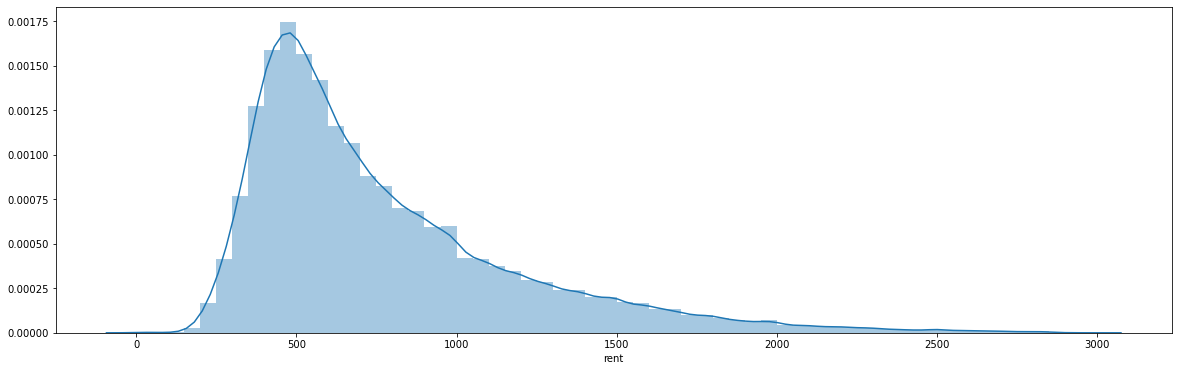

In [7]:
# distribution of the response variable
base_color = sns.color_palette()[0]

bin_edges = np.arange(0, df['rent'].max()+50, 50)

plt.figure(figsize=[20,6])
sns.distplot(df['rent'], bins=bin_edges);

The size of the flat is such an important indicator for price, that before I interpolate this numbers, I would first drop the few rows in which living space is zero

In [8]:
# remove all rows where living space is 0
df = df[df['livingSpace'] != 0]

In [9]:
# create a new variable for the rent/livingSpace (rent/m2)
df['rent_m2'] = df['rent'] / df['livingSpace']
df['rent_m2'].max()

1280.0

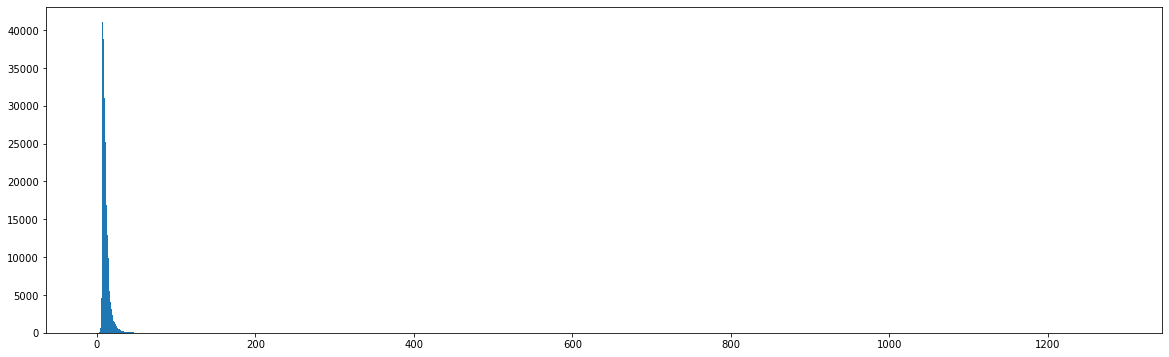

In [10]:
# distribution of the price per squared meter
bin_edges = np.arange(0, df['rent_m2'].max()+1, 1)

plt.figure(figsize=[20,6])
plt.hist(data=df, x='rent_m2', bins=bin_edges);

The price per squared meter is clearly biased! **Iterate over the data preparation process** to correct this issue. I will start by checking the amount of biased data:

In [11]:
for i in np.arange(98, 100, 0.1):
    print('{}: {}'.format(i, np.percentile(df.rent_m2, i)))

98.0: 25.0
98.1: 25.28735632183908
98.19999999999999: 25.634327272727212
98.29999999999998: 26.036894183114494
98.39999999999998: 26.532614965986248
98.49999999999997: 26.965251252311674
98.59999999999997: 27.485540879552502
98.69999999999996: 27.990377351597083
98.79999999999995: 28.49644444444349
98.89999999999995: 29.09090909090909
98.99999999999994: 29.833333333333332
99.09999999999994: 30.555555555555557
99.19999999999993: 31.385212510021063
99.29999999999993: 32.4390243902439
99.39999999999992: 33.57142857142857
99.49999999999991: 35.09768504100026
99.59999999999991: 36.97149895474101
99.6999999999999: 39.583333333333336
99.7999999999999: 43.54064516128543
99.89999999999989: 50.61145098036949


I am going to keep the 99% of the data and get rid of the outlier. For this I will use the same formula as in the data cleaning process

In [12]:
def get_rid_outl(df, list_num_var, percentile):
    """
    INPUT: 
    df: Dataframe
    list_num_var: List of the variables (columns) with outliers that need to be deleted
    percentile: float between 0 and 100: Percentage of the data that will be kept 
    
    OUTPUT:
    DataFrame with the defined amount of data. This means a DataFrame without outliers
    """
    
    perc_dict = {}
    for col in list_num_var: # first, calculate all the percentiles before removing any
        # row, otherwise you will remove more rows than necessary
        value_perc = np.nanpercentile(df[col], percentile)
        value_perc_dict = {col: value_perc}
        perc_dict.update(value_perc_dict)
        
    for var in list_num_var:    
        df = df.loc[(df[var] <= perc_dict[var]) ^ (df[var].isnull())] # include nan values
    
    return df

In [13]:
df = get_rid_outl(df, ['rent_m2'], 99)

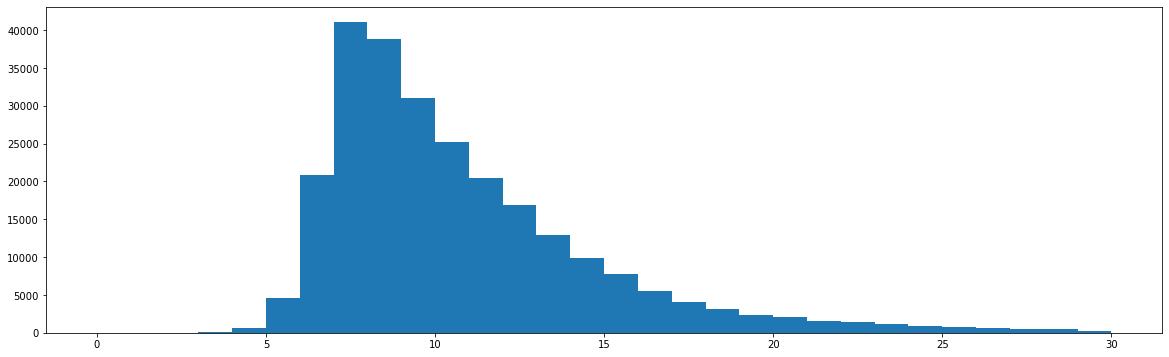

In [14]:
# look at the distribution of the price per squared meter again
bin_edges = np.arange(0, df['rent_m2'].max()+1, 1)

plt.figure(figsize=[20,6])
plt.hist(data=df, x='rent_m2', bins=bin_edges);

In [16]:
df.columns

Index(['Unnamed: 0', 'regio1', 'heatingType', 'newlyConst', 'balcony',
       'yearConstructed', 'noParkSpaces', 'hasKitchen', 'cellar',
       'livingSpace', 'condition', 'interiorQual', 'petsAllowed', 'lift',
       'typeOfFlat', 'geo_plz', 'noRooms', 'floor', 'numberOfFloors', 'garden',
       'regio2', 'regio3', 'energyEfficiencyClass', 'lastRefurbish', 'date',
       'rent', 'rent_m2'],
      dtype='object')

This is much better and as expected pretty similar to the rent price.

Further variables of interest: 
* Region
* Heating type
* Balcony
* Kitchen
* Cellar
* Condition
* Quality of the interior
* Lift
* Type of Flat
* Garden
* Efficiency Class (Energy)

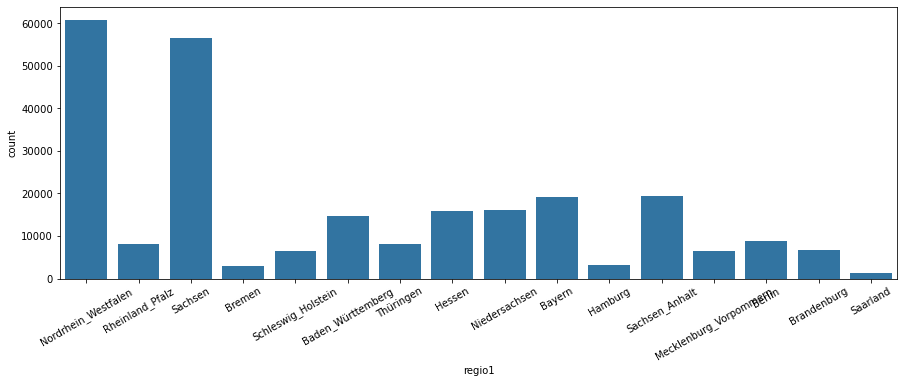

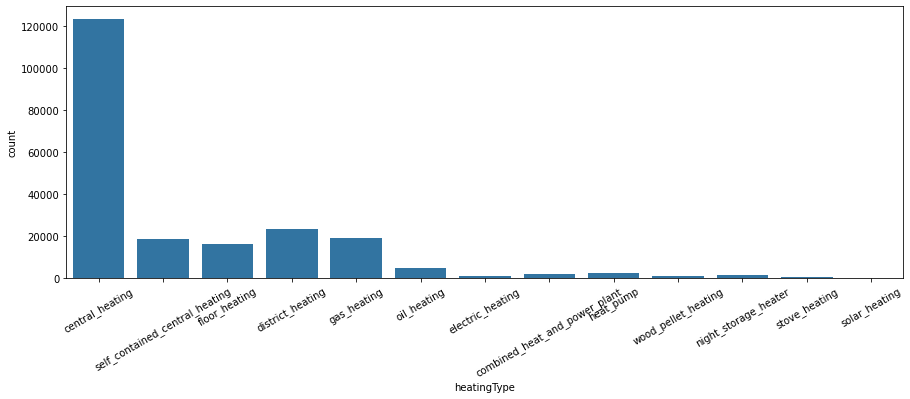

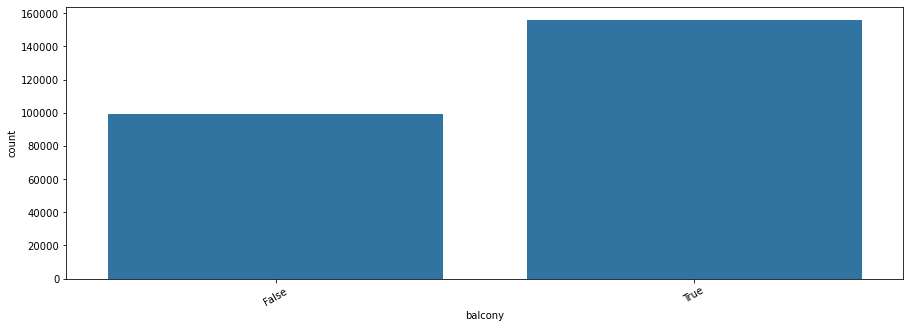

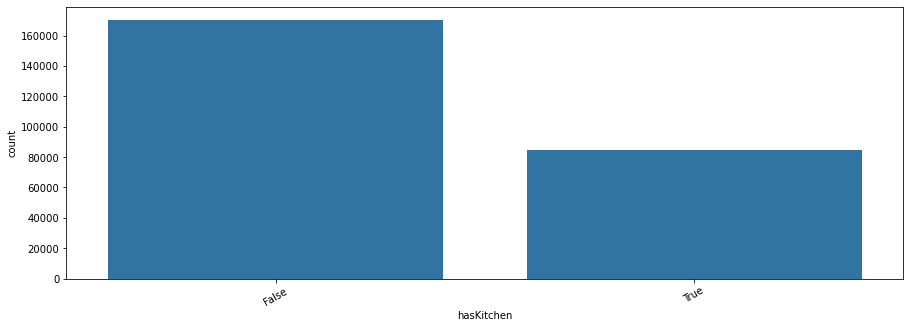

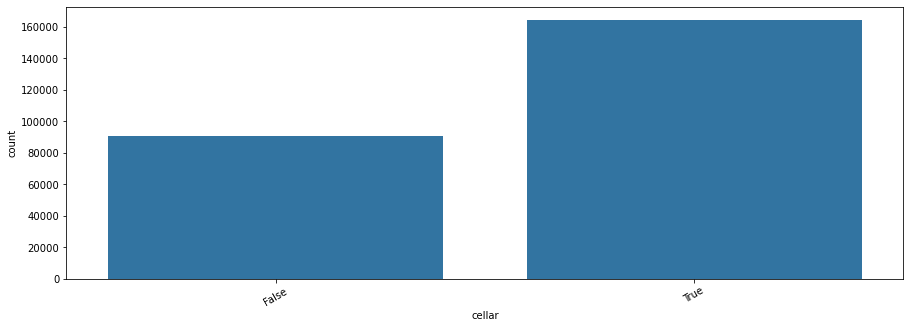

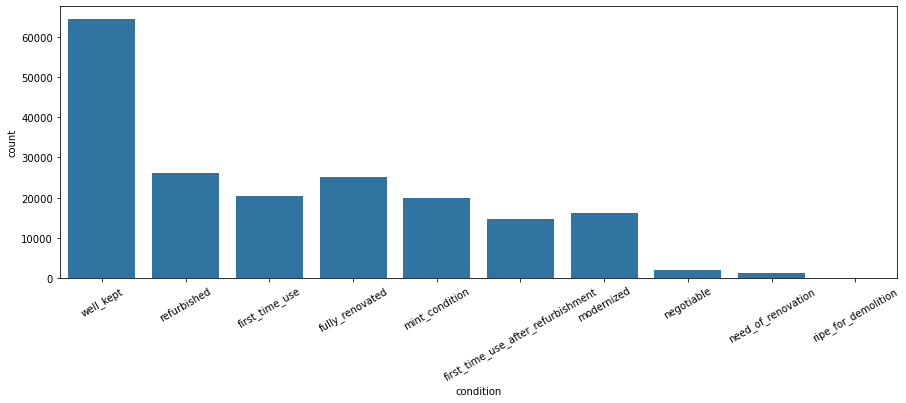

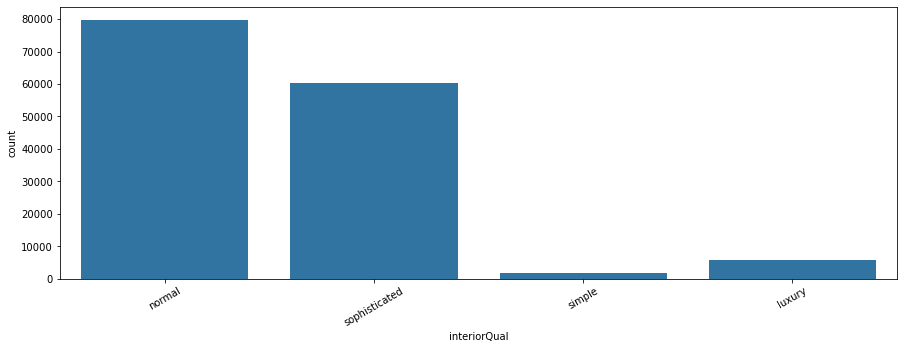

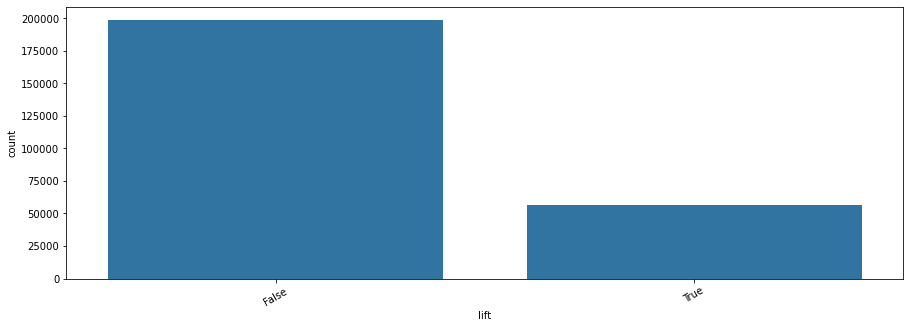

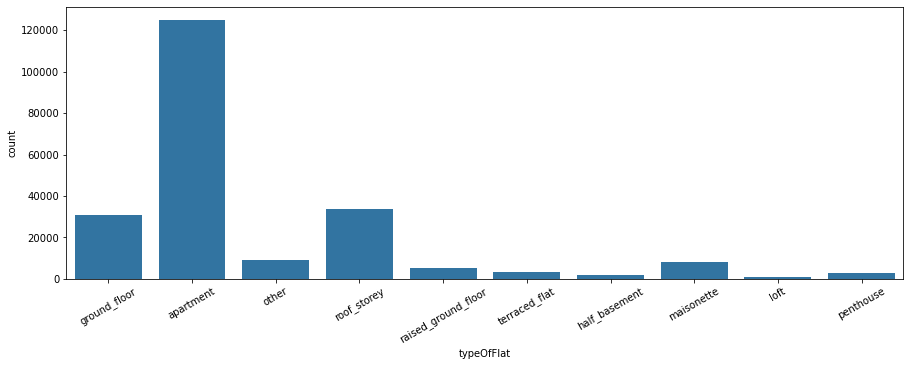

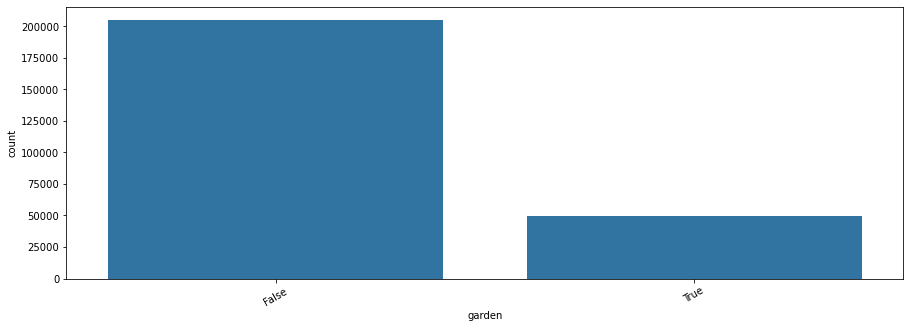

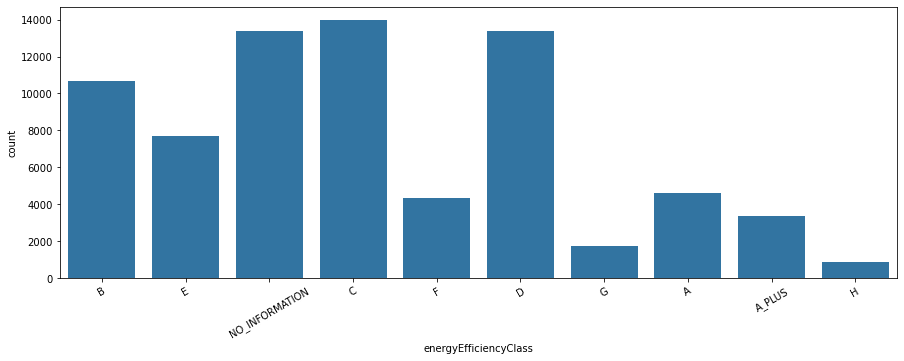

In [17]:
# Create a loop to generate all the graphs

vars_of_interest = ['regio1', 'heatingType', 'balcony', 
                    'hasKitchen', 'cellar', 
                    'condition', 'interiorQual', 'lift', 'typeOfFlat', 
                    'garden', 'energyEfficiencyClass']

for var in vars_of_interest:
    plt.figure(figsize=[15,5])
    sns.countplot(data = df, x=var, color=base_color)
    plt.xticks(rotation=30)

**Summary Univariate Assessment**
* The distribution of rent and rent/qm is as expected
* The number of offers accross germany is plausible
* There is high variation across all quality variables, which is good to fit the prediction model

## Bivariate Assessment

I am mostly interested in the variation of the response variable when the other variables change

<AxesSubplot:>

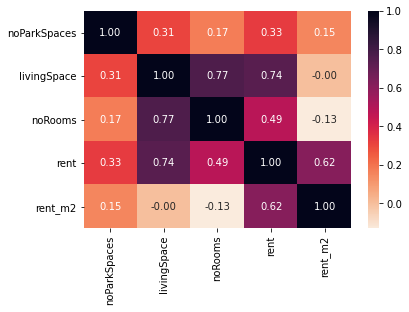

In [18]:
# get the correlation coefficient of the response variable to each other variable

# get a list of all the nummerical variables
list_num_vars = list(df.select_dtypes(include=['float', 'int']).columns)

# generate a heatmpa
sns.heatmap(df[list_num_vars].corr(), cmap='rocket_r', annot=True, fmt='.2f')

the negative correlation values between the rent/qm and other variables is clearly a fall of linear dependency. 

The number of rooms and the living space is clearly correlated - There might be a linear dependency, which has to be taken into account when fitting the linear model

**Now I would like to see the if the relation between the variables looks linear**

<Figure size 1080x1080 with 0 Axes>

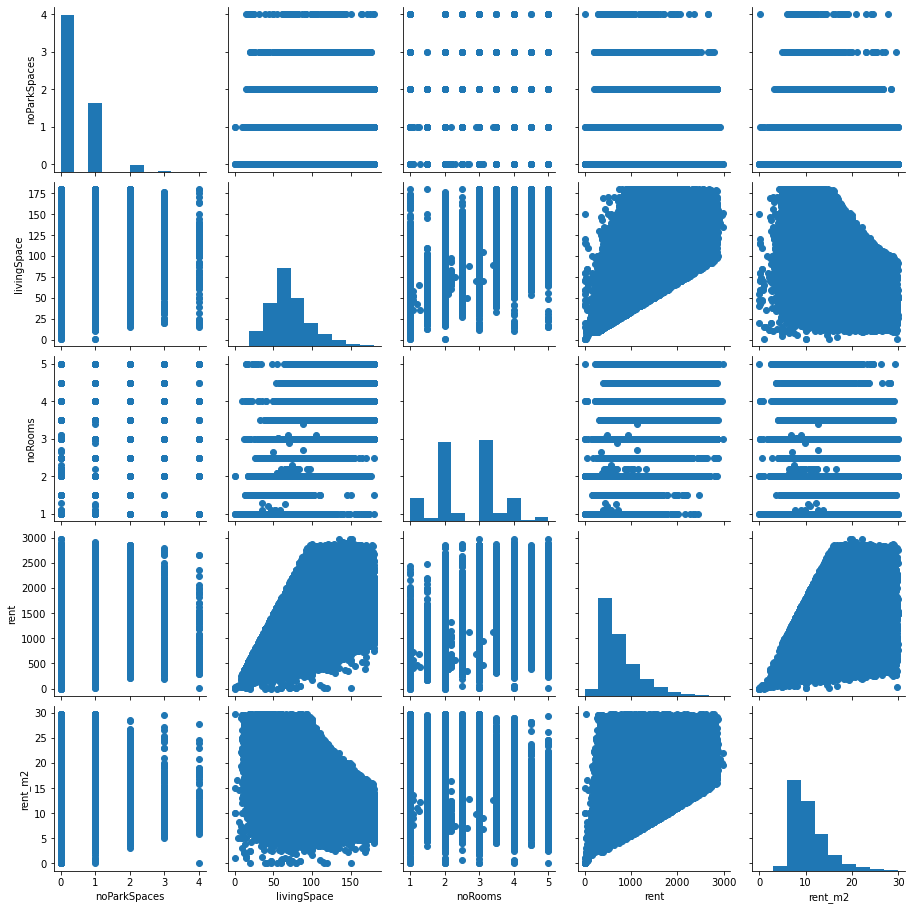

In [19]:
# create a scatter matrix with the numerical variables
plt.figure(figsize=[15,15])
g = sns.PairGrid(data=df, vars=list_num_vars)
g = g.map_offdiag(plt.scatter)
g.map_diag(plt.hist);

We can see  that some of the variability comes from the numerical variables but not all of it. Now it is time to check the categorical variables

In [20]:
# change all the ordered categorical variables to a categorical type
# yearConstructed, lastRefurbish, energyEfficiencyClass

# create lists with the right order
yearCon_order = list(df.yearConstructed.value_counts().sort_index().index)
yearRef_order = list(df.yearConstructed.value_counts().sort_index().index)
energy_order = ['A_PLUS', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'NO_INFORMATION']

# create the categorical elements
ordered_yearCon = pd.api.types.CategoricalDtype(ordered=True, categories=yearCon_order)
ordered_yearRef = pd.api.types.CategoricalDtype(ordered=True, categories=yearRef_order)
ordered_energy = pd.api.types.CategoricalDtype(ordered=True, categories=energy_order)

# change the data type to categories
df.yearConstructed = df.yearConstructed.astype(ordered_yearCon)
df.lastRefurbish = df.lastRefurbish.astype(ordered_yearRef)
df.energyEfficiencyClass = df.energyEfficiencyClass.astype(ordered_energy)

In [21]:
# get rid of all years before 1900 as NO_INFORMATION

# create a mask for year constructed and last refurbish
mask = df['yearConstructed'] < '1900'
mask2 = df['lastRefurbish'] < '1900'

df.loc[mask, 'yearConstructed'] = 'NO_INFORMATION'
df.loc[mask2, 'lastRefurbish'] = 'NO_INFORMATION'

In [22]:
# since the year of construction was already change to a category, I need to 
# update the category as well
yearCon_order = list(np.arange(1900, 2021, 1).astype(str))+ ['NO_INFORMATION']
yearRef_order = list(np.arange(1900, 2021, 1).astype(str))+ ['NO_INFORMATION']

# create the categorical elements
ordered_yearCon = pd.api.types.CategoricalDtype(ordered=True, categories=yearCon_order)
ordered_yearRef = pd.api.types.CategoricalDtype(ordered=True, categories=yearRef_order)

# change the data type to categories
df.yearConstructed = df.yearConstructed.astype(ordered_yearCon)
df.lastRefurbish = df.lastRefurbish.astype(ordered_yearRef)

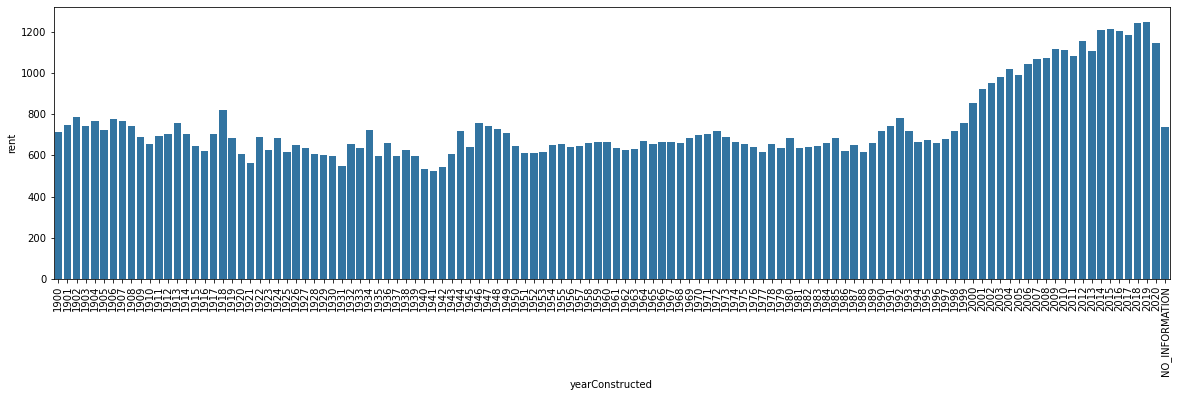

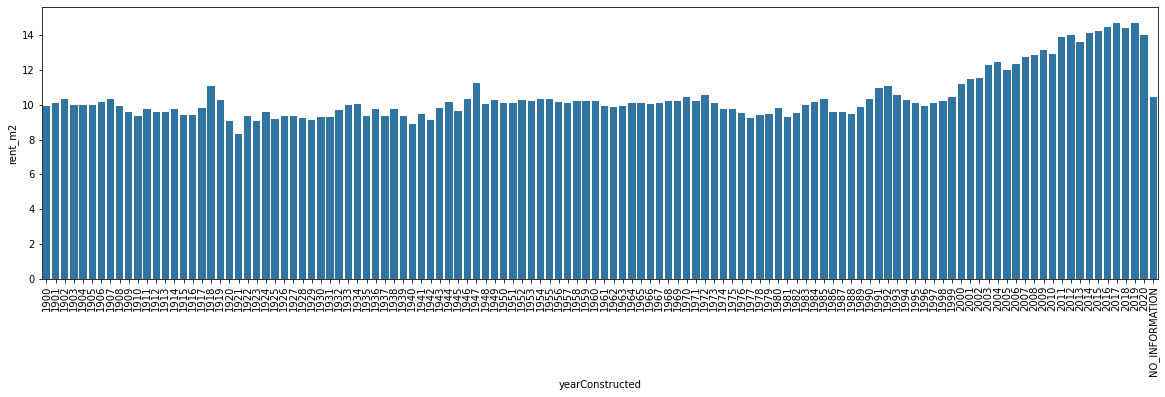

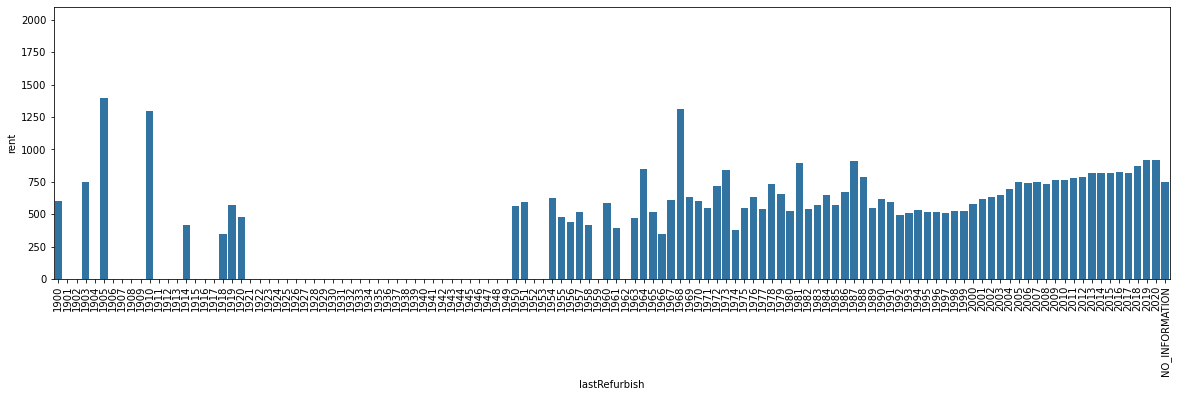

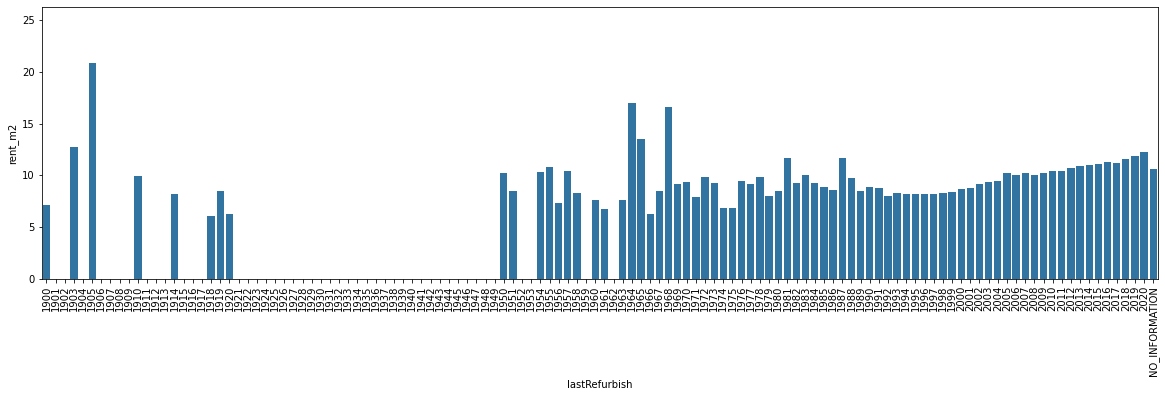

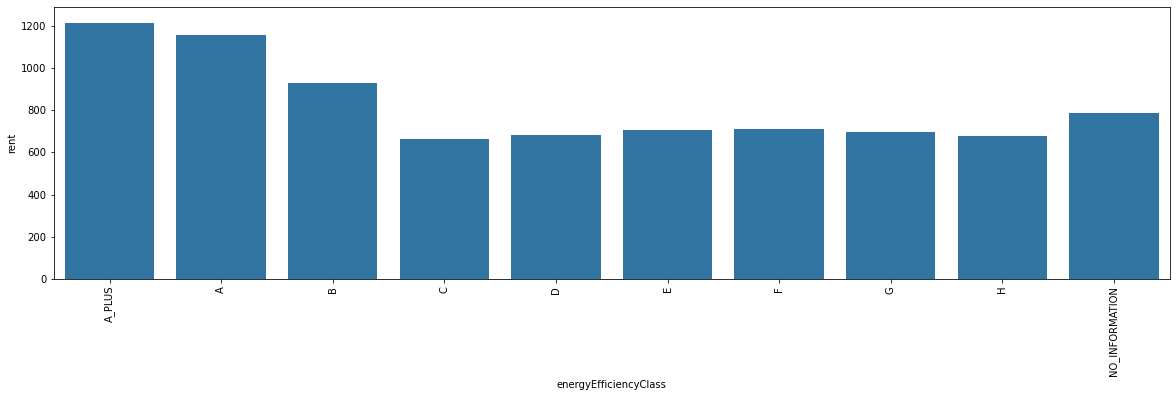

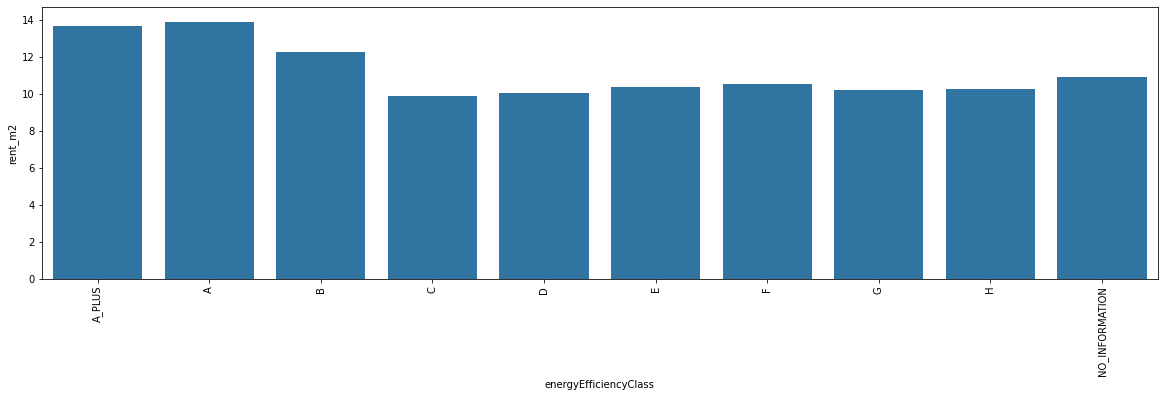

In [23]:
# create a barplot for each categorical value

list_cat_vars = ['yearConstructed', 'lastRefurbish', 'energyEfficiencyClass']
list_response_vars = ['rent', 'rent_m2']


for var in list_cat_vars:
    for rvar in list_response_vars:
        plt.figure(figsize=[20,5])
        sns.barplot(data=df, x=var, y=rvar, errwidth=0, color=base_color)
        plt.xticks(rotation=90)

As expected there is a lot of variation in the response variable for flats constructed in the last 20 years. Before that it seems that the year does not really have an impact in the response variable (keeping all other variables constant).

On the other hand the variable last refurbish does not make much sense, as there are some peaks for refurbish made 60 years ago. In contrast it can be expected, that the rent price increases as the time since the last refurbishment decreases.

The variation in the energy class is very interesting as it seems that people are willing to pay a premium for the highest energy classes, but are indifferent to the class in the the lower classes-segment. The better the energy class the higher the rent price (keeping all other variables constant)

Lets take a look to all other variables

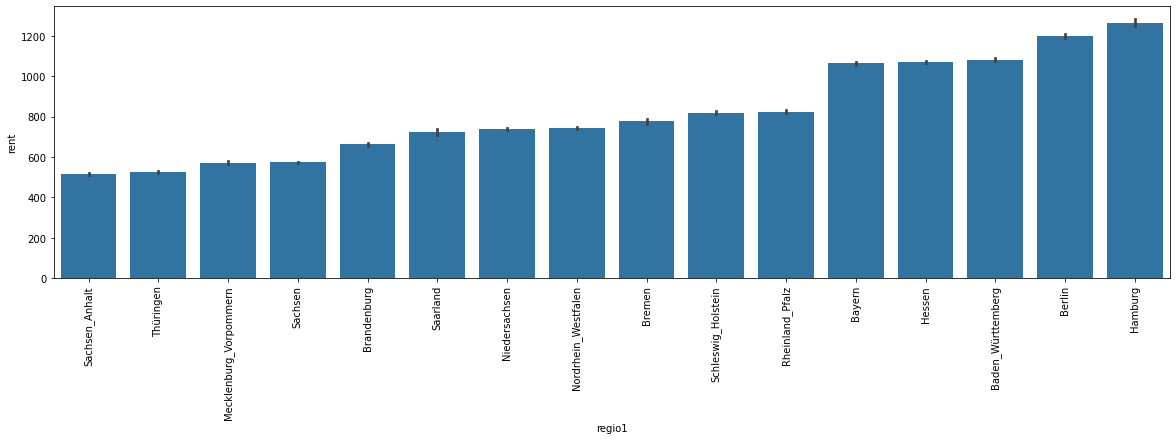

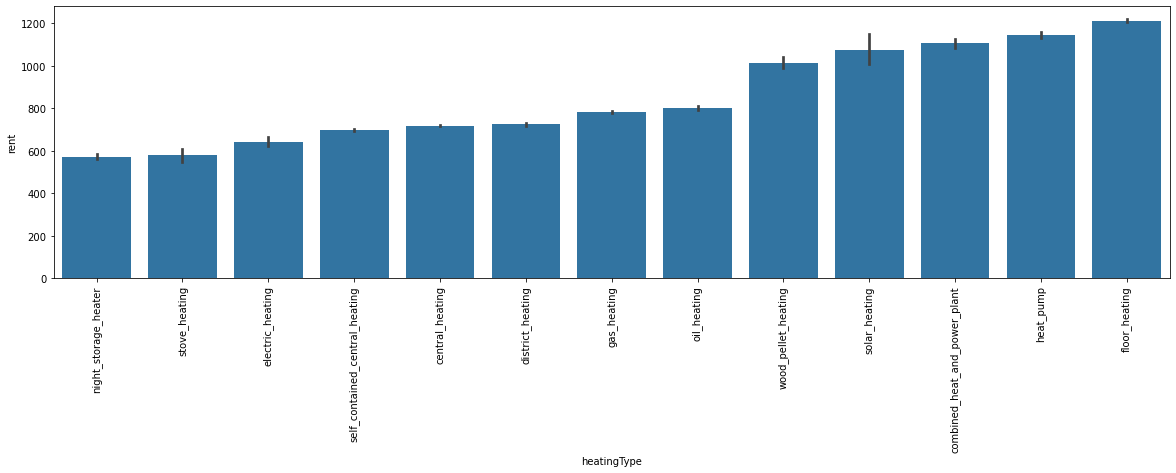

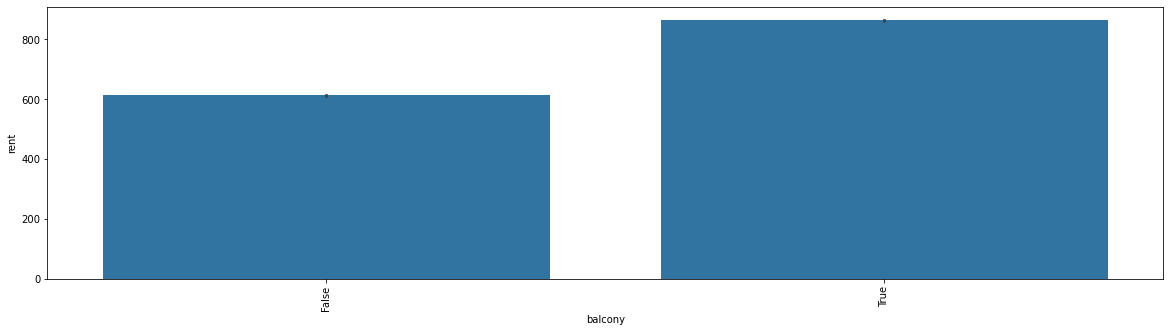

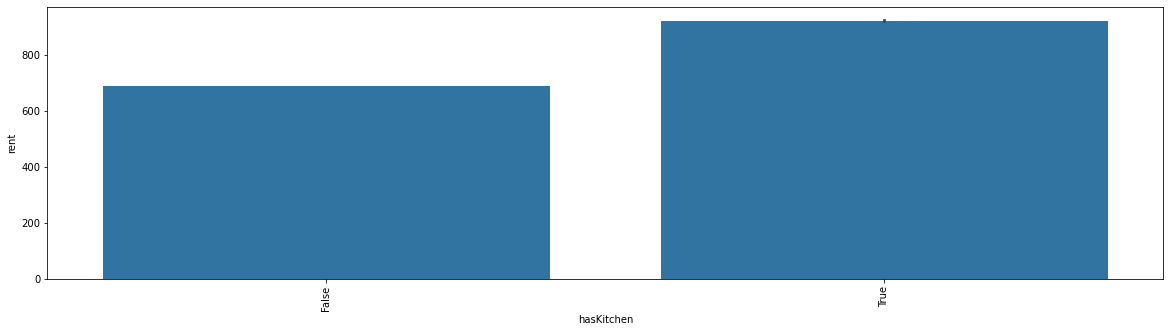

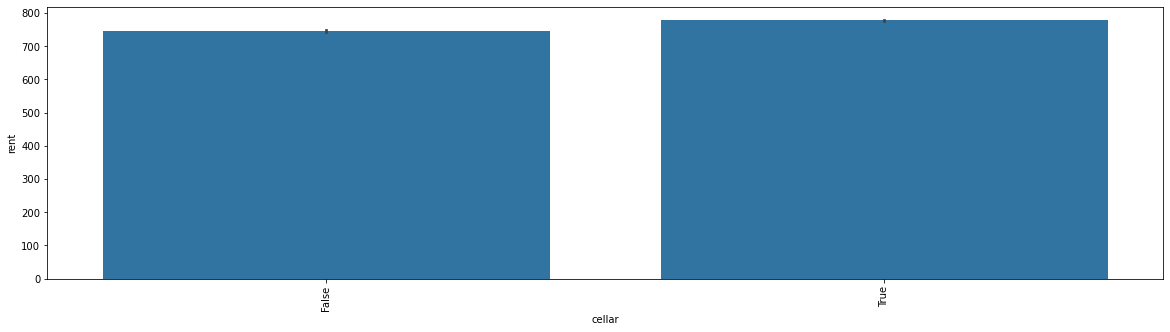

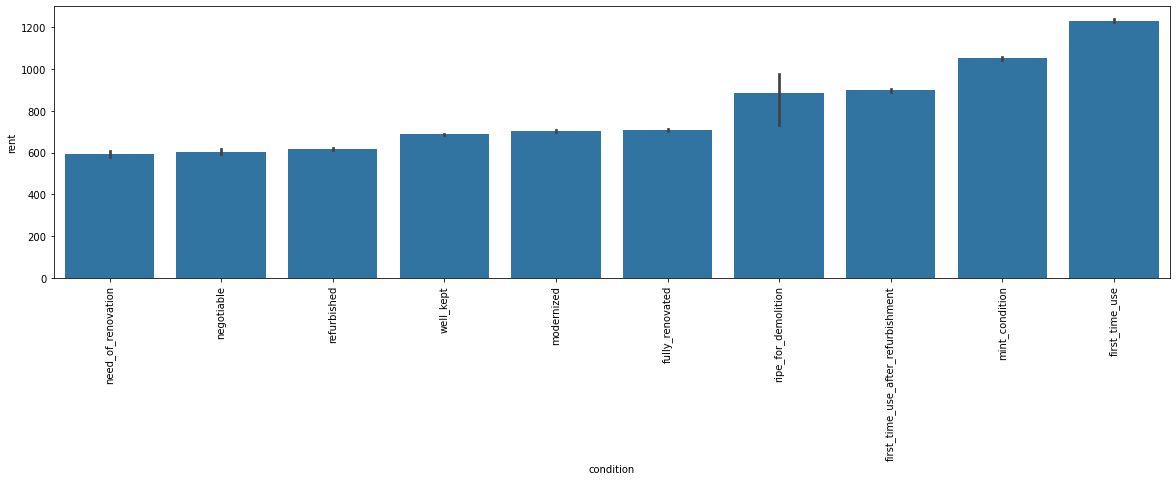

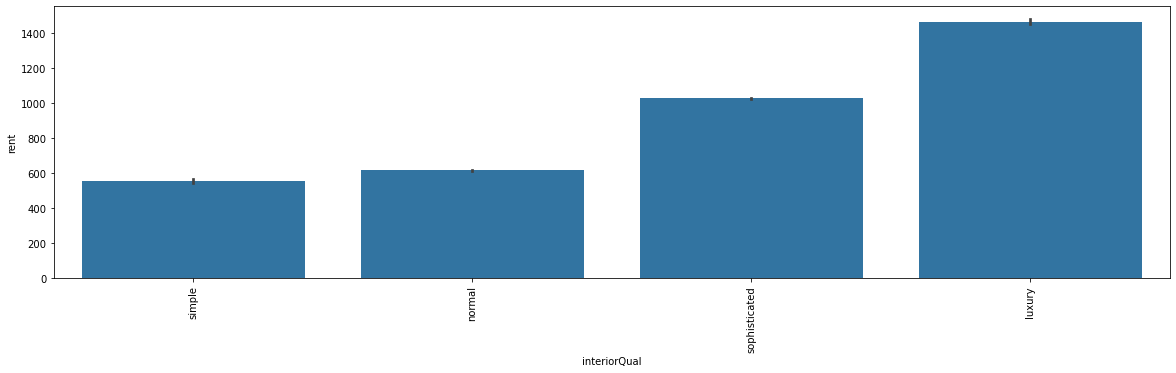

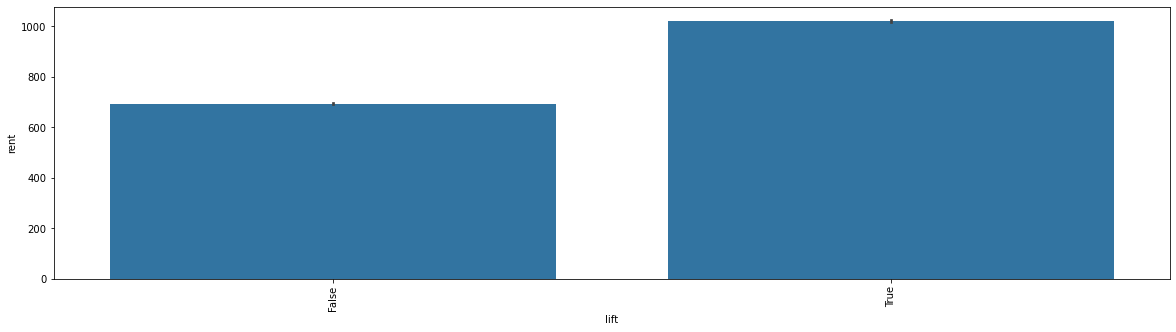

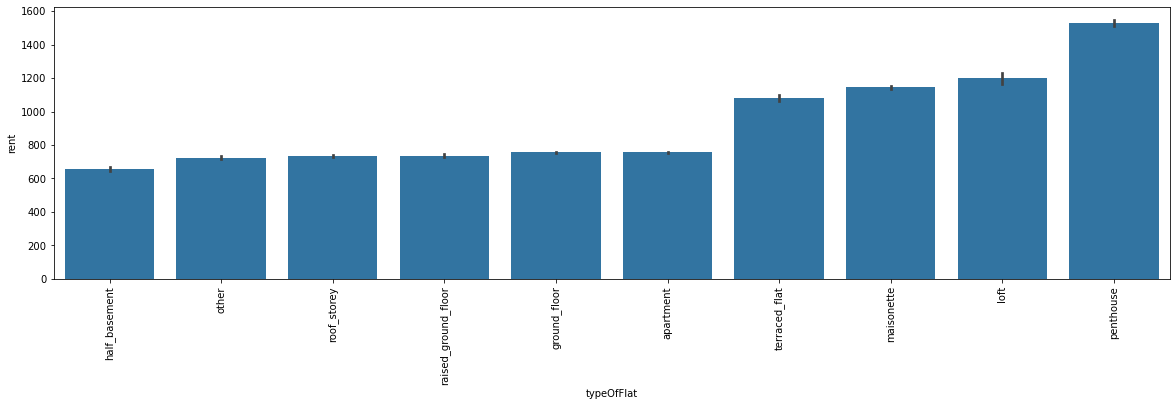

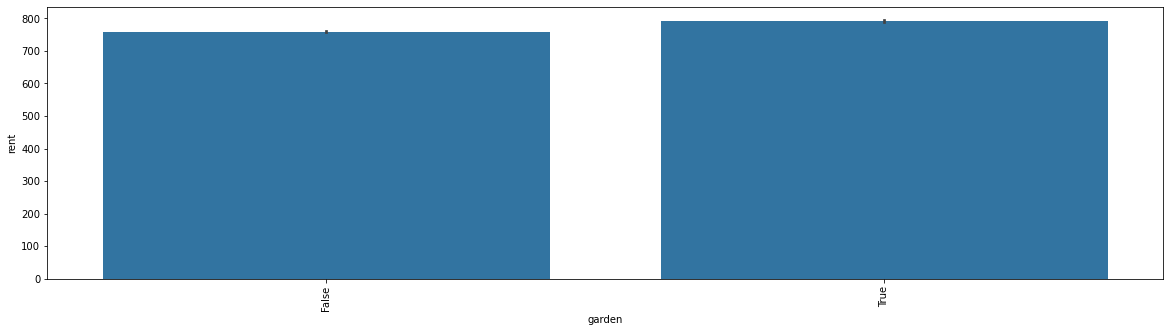

In [24]:
vars_of_interest = ['regio1', 'heatingType', 'balcony', 
                    'hasKitchen', 'cellar', 
                    'condition', 'interiorQual', 'lift', 'typeOfFlat', 
                    'garden']

for var in vars_of_interest:
    result = list(df.groupby([var]).rent.mean().sort_values().index)
    plt.figure(figsize=[20,5])
    sns.barplot(data=df, x=var, y='rent', color=base_color, order=result)
    plt.xticks(rotation=90);

There is a lot of variation in these variables, which is good as the prediction power of the model will profit from this

## Assessing the variables for Düsseldorf

In [25]:
# create a df with only the information for NRW
df_nrw = df[df.regio1 == 'Nordrhein_Westfalen'].copy()

In [26]:
df_nrw.shape

(60844, 27)

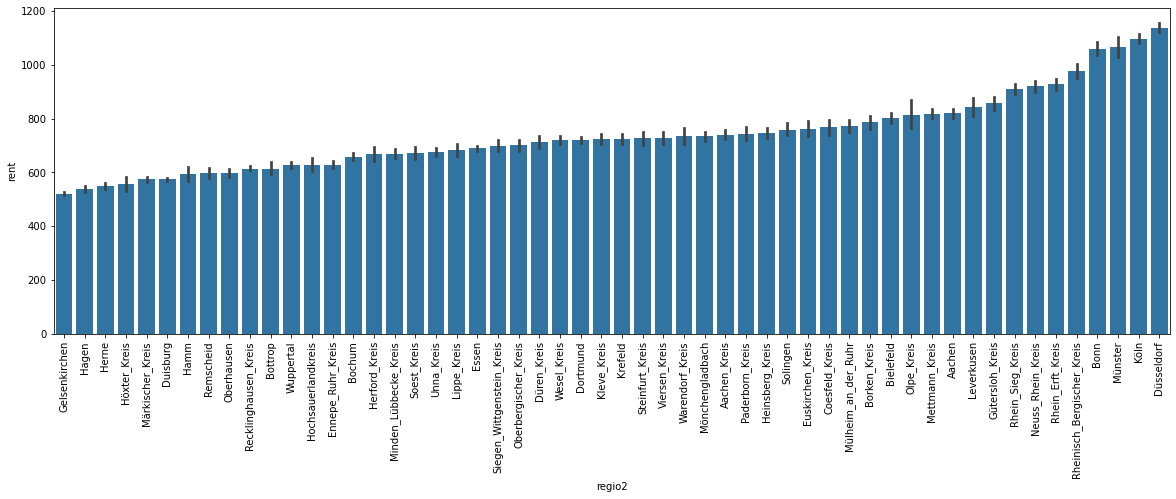

In [27]:
# get a view of the rent prices pro region in nrw
plt.figure(figsize=[20,6])
city_order = list(df_nrw.groupby(['regio2']).rent.mean().sort_values().index)
sns.barplot(data=df_nrw, x='regio2', y='rent', color=base_color, order=city_order)
plt.xticks(rotation=90);

Düsseldorf has the highest rents in Nordrhein Westfalen. Take a closer look to düsseldorf

In [28]:
# create a sub datafram for Düsseldorf

df_dus = df[df.regio2 == 'Düsseldorf'].copy()
df_dus.shape

(3391, 27)

In [29]:
df_dus.columns

Index(['Unnamed: 0', 'regio1', 'heatingType', 'newlyConst', 'balcony',
       'yearConstructed', 'noParkSpaces', 'hasKitchen', 'cellar',
       'livingSpace', 'condition', 'interiorQual', 'petsAllowed', 'lift',
       'typeOfFlat', 'geo_plz', 'noRooms', 'floor', 'numberOfFloors', 'garden',
       'regio2', 'regio3', 'energyEfficiencyClass', 'lastRefurbish', 'date',
       'rent', 'rent_m2'],
      dtype='object')

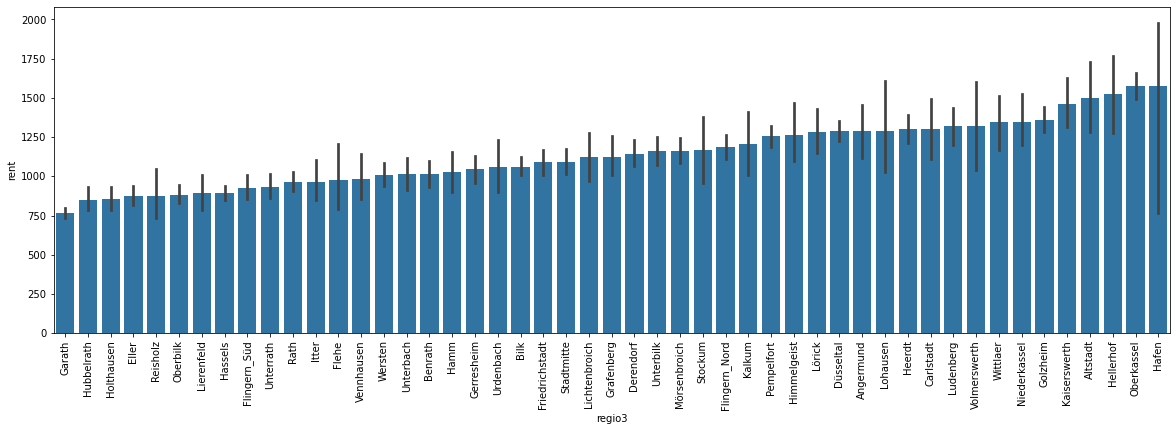

In [30]:
plt.figure(figsize=[20,6])
block_order = list(df_dus.groupby(['regio3']).rent.mean().sort_values().index)
sns.barplot(data=df_dus, x='regio3', y='rent', color=base_color, order=block_order)
plt.xticks(rotation=90);

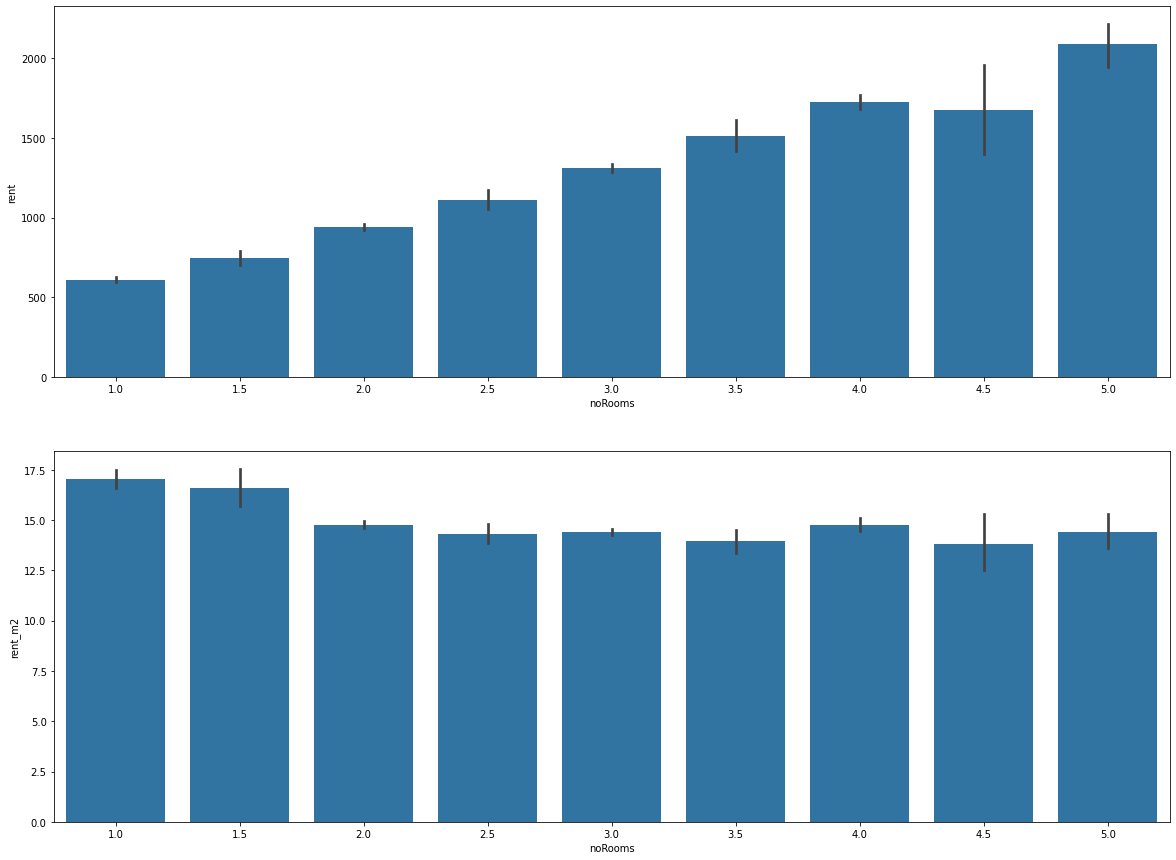

In [31]:
# impact of the number of rooms in the rent price

plt.figure(figsize=[20,15])

plt.subplot(2,1,1)
rooms_r_order = list(df_dus.groupby(['noRooms']).rent.mean().sort_values().index)
sns.barplot(data=df_dus, x='noRooms', y='rent', color=base_color);

plt.subplot(2,1,2)
rooms_rqm_order = list(df_dus.groupby(['noRooms']).rent_m2.mean().sort_values().index)
sns.barplot(data=df_dus, x='noRooms', y='rent_m2', color=base_color);

When normalizin by the living space the number of rooms do not the same variation, since some appartments could be lofts or else. As we saw before the number of rooms is correlated with the leaving space.